In [4]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely import affinity
import requests
import zipfile
import io

# Load world countries
world_url = "https://raw.githubusercontent.com/johan/world.geo.json/master/countries.geo.json"
world = gpd.read_file(world_url)
countries = world[world['name'].isin(['India', 'Jordan'])].copy()

# Load US states (via census TIGER shapefile)
us_states_url = "https://www2.census.gov/geo/tiger/GENZ2022/shp/cb_2022_us_state_500k.zip"
r = requests.get(us_states_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall("us_states_data")
us_states = gpd.read_file("us_states_data/cb_2022_us_state_500k.shp")

# Filter for California and Florida
states = us_states[us_states['NAME'].isin(['California', 'Florida'])].copy()
states = states.to_crs(epsg=4326)  # Match world CRS

# Standardize country/state names
states['name'] = states['NAME']
sel = pd.concat([countries[['name', 'geometry']], states[['name', 'geometry']]], ignore_index=True)

# Reproject to equal-area for area-based scaling
ea = sel.to_crs(epsg=6933)

# Compute area of India as reference
ref_area = ea.loc[ea['name'] == 'India', 'geometry'].area.values[0]
factors = {}
for idx, row in ea.iterrows():
    area = row.geometry.area
    factors[row['name']] = (ref_area / area) ** 0.5

# Scale about centroid
scaled = []
for idx, row in ea.iterrows():
    geom = row.geometry
    factor = factors[row['name']]
    cx, cy = geom.centroid.x, geom.centroid.y
    scaled_geom = affinity.scale(geom, xfact=factor, yfact=factor, origin=(cx, cy))
    scaled.append(scaled_geom)

ea['geometry'] = scaled

# Back to lat/lon
rescaled = ea.to_crs(epsg=4326)

# Plot
fig, ax = plt.subplots(figsize=(10, 7), dpi=300)
rescaled.plot(ax=ax, edgecolor='black', color='orange')

for name in rescaled['name']:
    print(f"Scaled: {name}, factor: {factors[name]:.2f}")

ax.set_axis_off()
plt.tight_layout()
plt.show()


SSLError: HTTPSConnectionPool(host='www2.census.gov', port=443): Max retries exceeded with url: /geo/tiger/GENZ2022/shp/cb_2022_us_state_500k.zip (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1000)')))

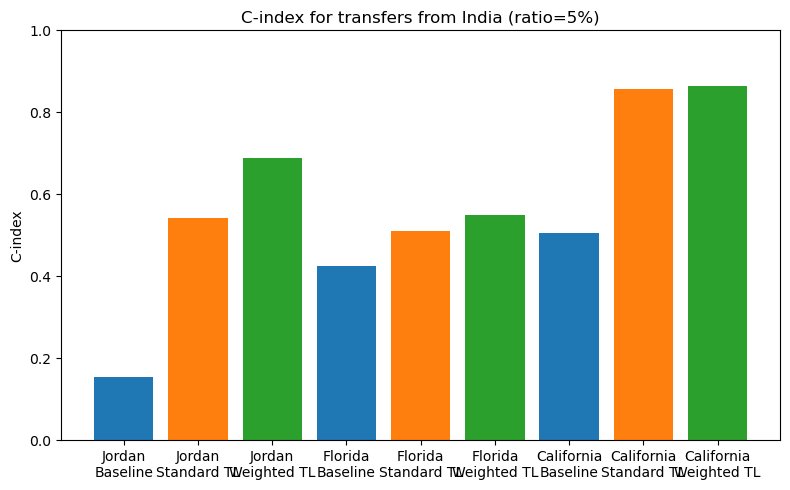

ValueError: 'Jordan→Jordan' is not in list

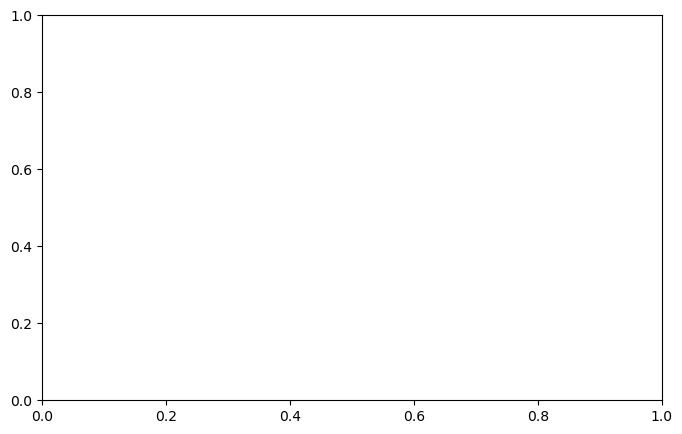

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

import matplotlib.pyplot as plt

# Prepare data
ratios = [5, 10, 20]
transfers = [
    "India→Jordan", "India→Florida", "India→California",
    "Jordan→India", "Jordan→Florida", "Jordan→California",
    "Florida→India", "Florida→Jordan", "Florida→California",
    "California→India", "California→Jordan", "California→Florida"
]
model_types = ["Baseline", "Standard TL", "Weighted TL"]

# C-index values for each (transfer, ratio, model_type)
# Fill in order: for each transfer, for each ratio, for each model_type
cindex_data = [
    # India→Jordan
    [0.155, 0.541, 0.689], [0.318, 0.493, 0.682], [0.196, 0.595, 0.405],
    # India→Florida
    [0.425, 0.510, 0.550], [0.526, 0.716, 0.710], [0.522, 0.552, 0.637],
    # India→California
    [0.506, 0.857, 0.864], [0.625, 0.836, 0.855], [0.618, 0.820, 0.850],
    # Jordan→India
    [0.768, 0.764, 0.762], [0.766, 0.749, 0.775], [0.786, 0.770, 0.781],
    # Jordan→Florida
    [0.425, 0.433, 0.421], [0.526, 0.619, 0.548], [0.522, 0.599, 0.619],
    # Jordan→California
    [0.506, 0.755, 0.748], [0.625, 0.718, 0.707], [0.618, 0.704, 0.744],
    # Florida→India
    [0.768, 0.739, 0.752], [0.766, 0.737, 0.767], [0.786, 0.751, 0.770],
    # Florida→Jordan
    [0.155, 0.196, 0.385], [0.318, 0.426, 0.426], [0.196, 0.324, 0.284],
    # Florida→California
    [0.506, 0.347, 0.628], [0.625, 0.443, 0.368], [0.618, 0.417, 0.373],
    # California→India
    [0.768, 0.753, 0.760], [0.766, 0.749, 0.762], [0.786, 0.760, 0.773],
    # California→Jordan
    [0.155, 0.615, 0.696], [0.318, 0.439, 0.709], [0.196, 0.601, 0.655],
    # California→Florida
    [0.425, 0.554, 0.494], [0.526, 0.593, 0.577], [0.522, 0.613, 0.585],
]

fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111, projection='3d')

# Prepare bar positions
n_transfers = len(transfers)
n_ratios = len(ratios)
n_models = len(model_types)

x_pos = []
y_pos = []
z_pos = []
dx = 0.6
dy = 0.6
dz = []

for t_idx in range(n_transfers):
    for r_idx in range(n_ratios):
        for m_idx in range(n_models):
            x_pos.append(r_idx + m_idx * 0.2)  # ratio axis, offset by model
            y_pos.append(t_idx)
            z_pos.append(m_idx)
            dz.append(cindex_data[t_idx * n_ratios + r_idx][m_idx])

# Colors for models
colors = ['tab:blue', 'tab:orange', 'tab:green']
bar_colors = [colors[m_idx] for t_idx in range(n_transfers) for r_idx in range(n_ratios) for m_idx in range(n_models)]

ax.bar3d(x_pos, y_pos, [0]*len(z_pos), dx, dy, dz, color=bar_colors, shade=True)

# Set axes labels
ax.set_xlabel('Ratio (%)')
ax.set_ylabel('Transfer')
ax.set_zlabel('C-index')

ax.set_xticks([0, 1, 2])
ax.set_xticklabels(['5%', '10%', '20%'])
ax.set_yticks(range(n_transfers))
ax.set_yticklabels(transfers)
ax.set_zlim(0, 1)

# Legend
for m_idx, model in enumerate(model_types):
    ax.bar3d([], [], [], [], [], [], color=colors[m_idx], label=model)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()